# 不均一系触媒上の反応解析（NEB法）

前章では有機分子を用いて、反応経路探索を行い活性化エネルギーを算出するNEB法の使い方を学びました。<br/>
本章では、より実用的な応用例として、不均一系触媒Rh上でのNO解離の反応解析を行ってみましょう。

流れとしては以下の目次のようになります。<br/>
触媒となるRh Slab部分の構造を作成し、その上に反応させたい対象となるNOを吸着させます。<br/>
その後、反応前後の状態を作成し、NEB法を用いて活性化エネルギーを算出します。

※本チュートリアルの内容はmatlantis-contribで公開されている計算事例を基にしています。

 - [matlantis-contrib/matlantis_contrib_examples/NEB_Solid_catalyst](https://github.com/matlantis-pfcc/matlantis-contrib/tree/main/matlantis_contrib_examples/NEB_Solid_catalyst)


<a id="chap0"></a>

## セットアップ

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display_png
from IPython.display import Image as ImageWidget
import ipywidgets as widgets
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import glob
from pathlib import Path
from PIL import Image, ImageDraw

import ase
from ase import Atoms, units
from ase.units import Bohr,Rydberg,kJ,kB,fs,Hartree,mol,kcal
from ase.io import read, write
from ase.build import surface, molecule, add_adsorbate
from ase.constraints import FixAtoms, FixedPlane, FixBondLength, ExpCellFilter
from ase.neb import NEB
from ase.vibrations import Vibrations
from ase.thermochemistry import IdealGasThermo
from ase.visualize import view
from ase.build.rotate import minimize_rotation_and_translation
from ase.optimize import BFGS, LBFGS, FIRE
from ase.md import MDLogger
from ase.io import read, write, Trajectory
from ase.build import sort

from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
from pfp_api_client.pfp.estimator import Estimator, EstimatorCalcMode


estimator = Estimator(calc_mode=EstimatorCalcMode.CRYSTAL_PLUS_D3, model_version="v2.0.0")
calculator = ASECalculator(estimator)

<a id="chap1"></a>

## 1. BulkからSlab作成

触媒として、今回はRhを用います。<br/>
Slab構造は、Bulk構造の構造ファイルから作成ができます。

### 1-1 Bulk構造を読み込みから作成まで

今回はMaterials Projectからダウンロードしたcifファイルをinputフォルダに入れて読み込み

Input cif file is from  
A. Jain*, S.P. Ong*, G. Hautier, W. Chen, W.D. Richards, S. Dacek, S. Cholia, D. Gunter, D. Skinner, G. Ceder, K.A. Persson (*=equal contributions)  
The Materials Project: A materials genome approach to accelerating materials innovation
APL Materials, 2013, 1(1), 011002.  
[doi:10.1063/1.4812323](http://dx.doi.org/10.1063/1.4812323)  
[[bibtex]](https://materialsproject.org/static/docs/jain_ong2013.349ca3156250.bib)  
Licensed under [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)  

In [2]:
bulk = read("../input/Rh_mp-74_conventional_standard.cif")
print("原子数 =", len(bulk))
print("initial 格子定数 =", bulk.cell.cellpar())


bulk.calc = calculator
opt = LBFGS(ExpCellFilter(bulk))
opt.run()
print ("optimized 格子定数 =", bulk.cell.cellpar())

原子数 = 4
initial 格子定数 = [ 3.843898  3.843898  3.843898 90.       90.       90.      ]
       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 04:35:03      -25.476236*       3.8371
LBFGS:    1 04:35:03      -24.667208*      15.0881
LBFGS:    2 04:35:04      -25.552678*       0.6707
LBFGS:    3 04:35:04      -25.554868*       0.1119
LBFGS:    4 04:35:04      -25.554928*       0.0009
optimized 格子定数 = [ 3.79293602  3.79293526  3.79293577 90.00004307 90.00000889 89.99999804]


[sort](https://wiki.fysik.dtu.dk/ase/ase/build/tools.html#ase.build.sort)関数は、元素番号に応じて順序をソートする関数です。

In [3]:
from pfcc_extras.visualize.view import view_ngl

bulk = bulk.repeat([2, 2, 2])
bulk = sort(bulk)
bulk.positions += [0.01, 0, 0]   # 面を切るときに変なところで切れるのを防ぐために少し下駄を履かせます。

view_ngl(bulk, representations=["ball+stick"])

### 1-2 Slab構造を作成まで

bulk構造から任意のミラー指数でslab構造を作成。<br/>
`miller_indices=(x,y,z)`で指定できます。 `makesurface` は中で [surface](https://wiki.fysik.dtu.dk/ase//ase/build/surface.html#create-specific-non-common-surfaces) 関数を使用して表面構造を作成しています。

In [4]:
from ase import Atoms
from ase.build import surface


def makesurface(
    atoms: Atoms, miller_indices=(1, 1, 1), layers=4, rep=[4, 4, 1]
) -> Atoms:
    s1 = surface(atoms, miller_indices, layers)
    s1.center(vacuum=10.0, axis=2)
    s1 = s1.repeat(rep)
    s1.set_positions(s1.get_positions() - [0, 0, min(s1.get_positions()[:, 2])])
    s1.pbc = True
    return s1

In [5]:
slab = makesurface(bulk, miller_indices=(1, 1, 1), layers=2, rep=[1, 1, 1])
slab = sort(slab)
# adjust `positions` before `wrap`
slab.positions += [1, 1, 0]
slab.wrap()

view_ngl(slab, representations=["ball+stick"])

### 1-3 作成したslabのz座標を確認

slabの最も高い座標確認（吸着構造を作成するときに必要）<br/>
slabの層ごとの座標を確認（何層目までを固定するのか決めるのに必要）

x         y             z symbol
0    1.007071  1.004083  7.937485e-08     Rh
1   10.394109  0.229853  2.189852e+00     Rh
2    2.348077  0.229853  2.189852e+00     Rh
3    1.007072  2.552543  2.189852e+00     Rh
4    6.371091  7.197923  2.189852e+00     Rh
..        ...       ...           ...    ...
59   1.007073  5.649464  6.569555e+00     Rh
60   1.007074  1.004084  6.569555e+00     Rh
61  -0.333934  6.423693  4.379704e+00     Rh
62   2.348077  6.423693  4.379704e+00     Rh
63   1.007071  8.746383  4.379704e+00     Rh

[64 rows x 4 columns]

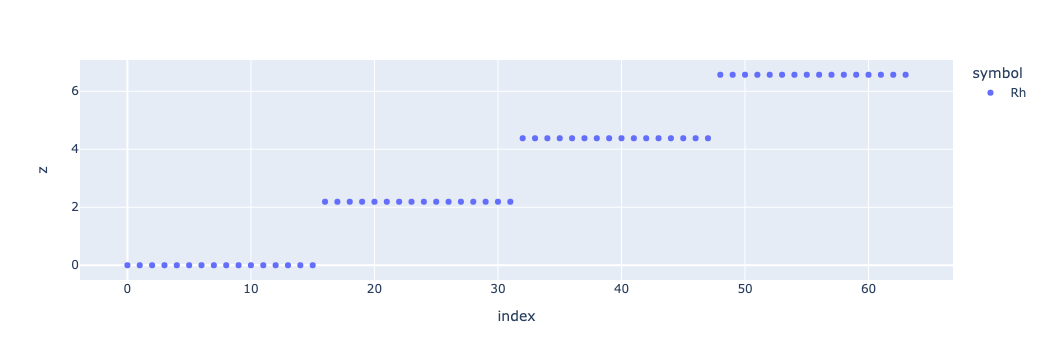

In [6]:
import plotly.express as px

# Check z_position of atoms
atoms = slab
df = pd.DataFrame({
    "x": atoms.positions[:, 0],
    "y": atoms.positions[:, 1],
    "z": atoms.positions[:, 2],
    "symbol": atoms.symbols,
})
display(df)

coord = "z"
df_sorted = df.sort_values(coord).reset_index().rename({"index": "atom_index"}, axis=1)
fig = px.scatter(df_sorted, x=df_sorted.index, y=coord, color="symbol", hover_data=["x", "y", "z", "atom_index"])
fig.show()

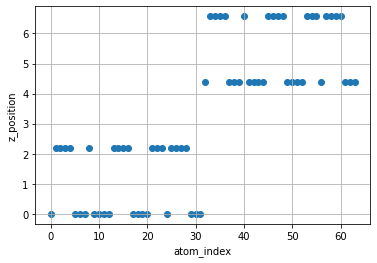

In [7]:
fig, ax = plt.subplots()
ax.scatter(df.index, df["z"])
ax.grid(True)
ax.set_xlabel("atom_index")
ax.set_ylabel("z_position")
plt.show(fig)

In [8]:
print("highest position (z) =", df["z"].max())

highest position (z) = 6.569555480615826


### 1-4 表面切り出したslab構造の下層を固定して構造最適化

[FixAtoms](https://wiki.fysik.dtu.dk/ase//ase/constraints.html#ase.constraints.FixAtoms) を用いることで、slab構造の下層の原子のみを固定してOptを実行できます。<br/>

ここでは１A以下を固定しており、一番下の層のみが固定されます。
表面の原子位置が緩和されるはずです。

In [9]:
%%time
# Fix atoms under z=1A
c = FixAtoms(indices=[atom.index for atom in slab if atom.position[2] <= 1])
slab.set_constraint(c)
slab.calc = calculator

os.makedirs("output", exist_ok=True)
BFGS_opt = BFGS(slab, trajectory="output/slab_opt.traj")#, logfile=None)
BFGS_opt.run(fmax=0.005)

      Step     Time          Energy         fmax
BFGS:    0 04:35:36     -373.605093        0.1779
BFGS:    1 04:35:36     -373.612169        0.1604
BFGS:    2 04:35:37     -373.649585        0.1412
BFGS:    3 04:35:37     -373.655036        0.1295
BFGS:    4 04:35:37     -373.688378        0.1402
BFGS:    5 04:35:37     -373.693581        0.1120
BFGS:    6 04:35:37     -373.700550        0.0249
BFGS:    7 04:35:37     -373.700798        0.0069
BFGS:    8 04:35:37     -373.700871        0.0001
CPU times: user 95.8 ms, sys: 10.3 ms, total: 106 ms
Wall time: 777 ms


True

実際のOptの経過を見てみると、上3層のみの構造最適化がされている事がわかります。

In [10]:
view_ngl(Trajectory("output/slab_opt.traj"), representations=["ball+stick"])

In [11]:
slabE = slab.get_potential_energy()
print(f"slab E = {slabE} eV")

slab E = -373.7008709380485 eV


In [12]:
# Save slab structure
os.makedirs("output/structures/", exist_ok=True)
write("output/structures/Slab_Rh_111.xyz", slab)

<a id="chap2"></a>

## 2. MoleculeをSlab上に配置、始状態（反応前）と終状態（反応後）を作成

### 2-1 吸着する分子読み込み、構造最適化後のpotential energyを得ましょう。

今回はaseの[molecule module](https://wiki.fysik.dtu.dk/ase/ase/build/build.html)を使います。<br/>
cif file, sdf fileなどからの読み込みもbulk構造を読み込みと同じように実施すればできます。

In [13]:
molec = molecule("NO")
# molec = read("xxxxxx.sdf") # sdf fileの読み込み例

In [14]:
molec.calc = calculator
BFGS_opt = BFGS(molec, trajectory="output/molec_opt.traj", logfile=None)
BFGS_opt.run(fmax=0.005)
molecE = molec.get_potential_energy()
print(f"molecE =　{molecE} eV")

molecE =　-7.247501804463887 eV


In [15]:
view_ngl(Trajectory("output/molec_opt.traj"), representations=["ball+stick"])

### 2-2 吸着E計算

吸着状態を作成しましょう。
ここでは、[add_adsorbate](https://wiki.fysik.dtu.dk/ase//ase/build/surface.html#ase.build.add_adsorbate)関数を用いて`slab` 上部に `molec` を配置しています。

In [16]:
mol_on_slab = slab.copy()

# slab最表面から分子を配置する高さと、x,y positionを入力してください。
# あとで調整できるので、適当で大丈夫です。
add_adsorbate(mol_on_slab, molec, height=3, position=(8, 4))
c = FixAtoms(indices=[atom.index for atom in mol_on_slab if atom.position[2] <= 1])
mol_on_slab.set_constraint(c)

#### SurfaceEditor

`SurfaceEditor`というクラスを用いて分子の吸着位置最適化を行います。

<使用方法>

1. `SurfaceEditor(atoms).display()` で編集したい構造を表示しましょう。
2. atoms z>で動かしたい分子のindexを取得しましょう。1-3で確認したslab構造の最も高い座標より上にいるのが分子です。<br/>設定すると下のボックスに選択された分子のindexのみが入ります。
3. move, rotateのXYZ+-で分子のみを移動、角度変更できますので、位置を調整してください。<br/>この際、Ball sizeを調整すると吸着サイトが見やすくなります。
4. "Run mini opt" ボタンで、BFGSによる構造最適化を指定ステップ実施できます。

今回は以下の論文を参考に吸着構造を作成してみます。

”First-Principles Microkinetic Analysis of NO + CO Reactions on Rh(111) Surface toward Understanding NOx Reduction Pathways”
 - https://pubs.acs.org/doi/10.1021/acs.jpcc.8b05906

今回の例では、"X-"を3回、"Y+"を１回、"Z-"を４回押すことでHCPサイトの吸着を行うための初期構造を作ることができます。<br/>
吸着のFCCサイト、HCPサイトに関しては以下の図をご覧ください。

<blockquote>
<figure>
<img src="https://www.researchgate.net/profile/Monica-Pozzo/publication/5521348/figure/fig1/AS:281313635520514@1444081805255/Colour-Possible-adsorption-sites-top-bridge-hollow-hcp-and-hollow-fcc-for-hydrogen.png"/>
<figcaption>(Colour) Possible adsorption sites (top, bridge, hollow-hcp and hollow-fcc) for hydrogen (dark red) on the Mg(0001) surface (light blue).<br/>
from <a href="https://www.researchgate.net/figure/Colour-Possible-adsorption-sites-top-bridge-hollow-hcp-and-hollow-fcc-for-hydrogen_fig1_5521348">https://www.researchgate.net/figure/Colour-Possible-adsorption-sites-top-bridge-hollow-hcp-and-hollow-fcc-for-hydrogen_fig1_5521348</a>
</figcaption>
</figure>
</blockquote>

In [17]:
# SurfaceEditor にはcalculator がSet されている必要があります。
mol_on_slab.calc = calculator

In [18]:
from pfcc_extras.visualize.surface_editor import SurfaceEditor


se = SurfaceEditor(mol_on_slab)
se.display()

In [19]:
c = FixAtoms(indices=[atom.index for atom in mol_on_slab if atom.position[2] <= 1])
mol_on_slab.set_constraint(c)
BFGS_opt = BFGS(mol_on_slab, logfile=None)
BFGS_opt.run(fmax=0.005)
mol_on_slabE = mol_on_slab.get_potential_energy()
print(f"mol_on_slabE = {mol_on_slabE} eV")

mol_on_slabE = -383.42472898613465 eV


In [20]:
os.makedirs("output/ad_structures/",  exist_ok=True)
write("output/ad_structures/mol_on_Rh(111).cif", mol_on_slab)

/home/jovyan/.local/lib/python3.7/site-packages/ase/io/cif.py:787: UserWarning:

Occupancies present but no occupancy info for "{symbol}"



### 2-3 吸着E

Slabと分子それぞれが単体で存在していたときのエネルギーと、結合したときのエネルギー差を見ることで、吸着エネルギーが計算できます。

上記論文値では、1.79eVとなっています。値がずれているのは、論文ではRPBE汎関数が使われていますが、PFPではPBE汎関数が使われているところの違いが影響していそうです。

In [21]:
# Calculate adsorption energy
adsorpE = slabE + molecE - mol_on_slabE
print(f"Adsorption Energy: {adsorpE} eV")

Adsorption Energy: 2.476356243622263 eV


### 2-4 吸着構造をリスト化

In [22]:
ad_st_path = "output/ad_structures/*"
ad_stru_list = [(filepath, read(filepath)) for filepath in glob.glob(ad_st_path)]

In [23]:
pd.DataFrame(ad_stru_list)

0  \
0  output/ad_structures/mol_on_Rh(111).cif   

                                                   1  
0  (Atom('Rh', [1.0070910000000006, 1.00404816787...

In [24]:
No = 0
view_ngl(ad_stru_list[No][1] , representations=["ball+stick"])

### 2-5 IS構造を作る

ここでIS構造・FS構造を自分で作成し、NEBを行うための経路を作ります。<br/>
今回はこちらで作成しているものを用いるので、 [3. NEB計算](#chap3) に飛んで頂いても構いません。

In [148]:
filepath, atoms = ad_stru_list[No]
print(filepath)
IS = atoms.copy()

output/ad_structures/mol_on_Rh(111).cif


ここでは、FCCサイトに吸着している以下のような構造を作成してみましょう。

<figure>
　　　　<img src="./output/NO_dissociation_NO(fcc)_N(hcp)_O(hcp)/png/00000.png" width="150"/>
  <figcaption>
      始状態： FCCサイトにNOが吸着している構造
  </figcaption>
</figure>

In [149]:
IS.calc = calculator
SurfaceEditor(IS).display()

In [31]:
c = FixAtoms(indices=[atom.index for atom in IS if atom.position[2] <= 1])
IS.set_constraint(c)
BFGS_opt = BFGS(IS, logfile=None)
BFGS_opt.run(fmax=0.05)
IS.get_potential_energy()

-383.4438927158026

### 2-6 FS構造を作る

同様に終状態を作成します。<br/>
本チュートリアルでは、N, Oそれぞれが移動し、HCPサイトに吸着した、以下のような構造を考えてみます。

<figure>
　　　　<img src="./output/NO_dissociation_NO(fcc)_N(hcp)_O(hcp)/png/00001.png" width="150"/>
  <figcaption>
      終状態： N, OそれぞれがHCPサイトに吸着している構造
  </figcaption>
</figure>

In [27]:
FS = IS.copy()

In [28]:
FS.calc = calculator
SurfaceEditor(FS).display()

In [34]:
FS.calc = calculator
c = FixAtoms(indices=[atom.index for atom in FS if atom.position[2] <= 1])
FS.set_constraint(c)
BFGS_opt = BFGS(FS, logfile=None)
BFGS_opt.run(fmax=0.005)
FS.get_potential_energy()

-383.4438927158026

IS, FS構造を保存

In [29]:
filepath = Path(filepath).stem
# filepath = Path(ad_stru_list[No][0]).stem
os.makedirs(filepath, exist_ok=True)
write(filepath+"/IS.cif", IS)
write(filepath+"/FS.cif", FS)

<a id="chap3"></a>

## 3. NEB計算

### 3-1 NEB計算

今回はこちらで作成した始状態・終状態ファイルを用いて、反応経路探索を行います。<br/>
[matlantis-contrib/matlantis_contrib_examples/NEB_Solid_catalyst](https://github.com/matlantis-pfcc/matlantis-contrib/tree/main/matlantis_contrib_examples/NEB_Solid_catalyst)では、NO(fcc) -> N(fcc) + O(fcc) への反応に対するNEB計算を行っているので、<br/>
本Tutorialでは、NO(fcc) -> N(hcp) + O(hcp) の反応に対するNEB計算を試してみます。

In [25]:
!cp -r "../input/NO_dissociation_NO(fcc)_N(fcc)_O(fcc)" .
!cp -r "../input/NO_dissociation_NO(fcc)_N(hcp)_O(hcp)" .

In [26]:
# filepath = "NO_dissociation_NO(fcc)_N(fcc)_O(fcc)"
filepath = "NO_dissociation_NO(fcc)_N(hcp)_O(hcp)"

作成したIS, FS構造はこの様になっています。

In [27]:
IS = read(filepath+"/IS.cif")
FS = read(filepath+"/FS.cif")

view_ngl([IS, FS], representations=["ball+stick"], replace_structure=True)

In [28]:
from pfcc_extras.visualize.povray import traj_to_gif

traj_to_gif(
    [IS, FS],
    gif_filepath=f"./output/{filepath}/NEB_IS_FS.gif",
    pngdir=f"./output/{filepath}/png",
    rotation="-60x, 30y, 15z",
    clean=False,
)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.9s finished


<div style="clear:both;display:table">
<figure style="width:30%;float:left;margin:10px">
　　　　<img src="./output/NO_dissociation_NO(fcc)_N(hcp)_O(hcp)/png/00000.png"/>
  <figcaption>
      始状態: Initial State
  </figcaption>
</figure>
<figure style="width:30%;float:left;margin:10px">
　　　　<img src="./output/NO_dissociation_NO(fcc)_N(hcp)_O(hcp)/png/00001.png"/>
  <figcaption>
      終状態: Final State
  </figcaption>
</figure>
</div>

<figure>
</figure>

In [29]:
c = FixAtoms(indices=[atom.index for atom in IS if atom.position[2] <= 1])
IS.calc = calculator
IS.set_constraint(c)
BFGS_opt = BFGS(IS, logfile=None)
BFGS_opt.run(fmax=0.005)
print(f"IS {IS.get_potential_energy()} eV")

c = FixAtoms(indices=[atom.index for atom in FS if atom.position[2] <= 1])
FS.calc = calculator
FS.set_constraint(c)
BFGS_opt = BFGS(FS, logfile=None)
BFGS_opt.run(fmax=0.005)
print(f"FS {FS.get_potential_energy()} eV")

IS -382.69646651708166 eV
FS -383.3367968805733 eV


In [30]:
beads = 21

NEBでparallel = True, allowed_shared_calculator=Falseにしたほうが、高速に処理が進みます。

In [31]:
b0 = IS.copy()
b1 = FS.copy()
configs = [b0.copy() for i in range(beads-1)] + [b1.copy()]
for config in configs:
    # Calculator must be set separately with NEB parallel=True, allowed_shared_calculator=False.
    estimator = Estimator(calc_mode=EstimatorCalcMode.CRYSTAL_PLUS_D3, model_version="v2.0.0")
    calculator = ASECalculator(estimator)
    config.calc = calculator

まずはNEBを用いて反応経路候補となる`configs`の線形補間を行います。

In [32]:
# k： spring constant. It was stable to when reduced to 0.05
neb = NEB(configs, k=0.05, parallel=True, climb=True, allow_shared_calculator=False)   
neb.interpolate()

線形補間直後の反応経路候補を確認

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  21 out of  21 | elapsed:   14.1s finished


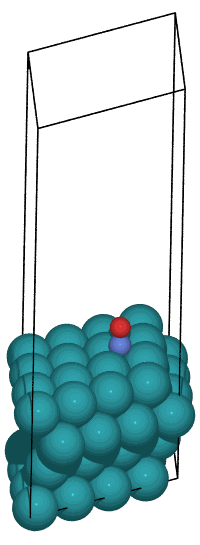

In [33]:
traj_to_gif(
    configs,
    gif_filepath=f"output/{filepath}/NEB_interpolate.gif",
    rotation="-60x, 30y, 15z"
)
ImageWidget(f"output/{filepath}/NEB_interpolate.gif")

In [34]:
view_ngl(configs, representations=["ball+stick"], replace_structure=True)

ここから最適化を行います。

fmaxは0.05以下が推奨。小さすぎると収束に時間がかかります。
一回目のNEB計算は収束条件を緩め（0.2など）で実行し、無理のない反応経路が描けていたら収束条件を厳しくするほうが安定して計算できます。
緩めの収束条件で異常な反応経路となる場合はIS, FS構造を見直してください。

計算時間は十分程度かかるため、待つ必要があります。途中経過を確認したい時は`neb_log.txt`を参照しましょう。

In [35]:
%%time
steps=2000

relax = FIRE(neb, trajectory=None, logfile=filepath+"/neb_log.txt")

# fmax<0.05 recommended. It takes time when it is smaller.
# 1st NEB calculation can be executed with loose condition (Ex. fmax=0.2),
# and check whether reaction path is reasonable or not.
# If it is reasonable, run 2nd NEB with tight fmax condition.
# If the reaction path is abnormal, check IS, FS structure.
relax.run(fmax=0.1, steps=steps)

CPU times: user 6.54 s, sys: 1.26 s, total: 7.8 s
Wall time: 46.9 s


True

１回目の緩めの収束後、反応経路が異常でないかを確認。

In [36]:
view_ngl(configs, representations=["ball+stick"], replace_structure=True)

反応経路が問題ないことを確認後、収束条件をきつくして2回目収束を実行。

In [37]:
# additional calculation
steps = 10000
relax.run(fmax=0.02, steps=steps)              

True

In [38]:
write(filepath+"/NEB_images.xyz", configs)

<a id="chap4"></a>

## 4. NEB計算結果の確認と遷移状態構造取得

まずはいくつかの方法で可視化してみます。今回はpng --> gifファイルを作成してみます。

In [39]:
configs = read(filepath+"/NEB_images.xyz", index=":")

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  21 out of  21 | elapsed:   13.3s finished


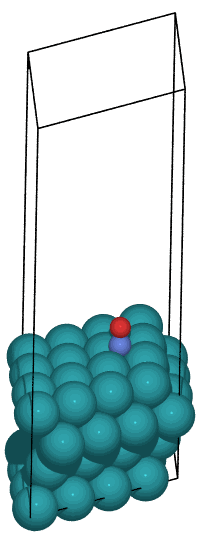

In [40]:
from pfcc_extras.visualize.povray import traj_to_gif

traj_to_gif(
    configs,
    gif_filepath=f"output/{filepath}/NEB_result.gif",
    rotation="-60x, 30y, 15z"
)
ImageWidget(f"output/{filepath}/NEB_result.gif")

TS構造となったIndexを確認。<br/>
Energy, Forceをみてみると、`index=12` で、エネルギーが最大、Forceが０付近の[鞍点](https://ja.wikipedia.org/wiki/%E9%9E%8D%E7%82%B9) (後述)に達している事がわかります。

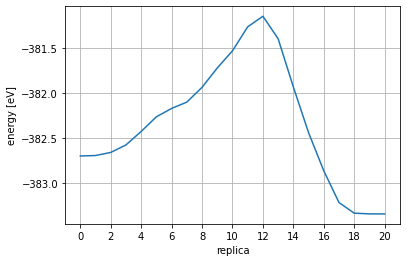

In [41]:
for config in configs:
    config.calc = calculator
energies = [config.get_total_energy() for config in configs]

plt.plot(range(len(energies)),energies)
plt.xlabel("replica")
plt.ylabel("energy [eV]")
plt.xticks(np.arange(0, len(energies), 2))
plt.grid(True)
plt.show()

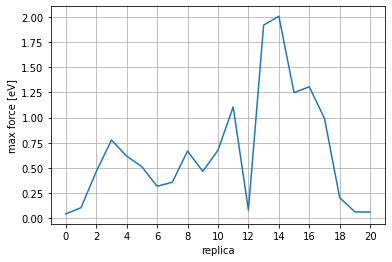

In [42]:
def calc_max_force(atoms):
    return ((atoms.get_forces() ** 2).sum(axis=1).max()) ** 0.5

mforces = [calc_max_force(config) for config in configs]
plt.plot(range(len(mforces)), mforces)
plt.xlabel("replica")
plt.ylabel("max force [eV]")
plt.xticks(np.arange(0, len(mforces), 2))
plt.grid(True)
plt.show()

max forceのPlotで確認すべきことは以下の３点で、forceが0に近い値になっていることです。

 - 始状態 (index=0)
 - 遷移状態 (index=12)
 - 終状態 (index=20)

ただし、今回のように`FixAtoms`を行って固定している原子がある場合、その部分のForceが大きいと0にはならないことがあります。

初期構造　`index=0` と、遷移状態 `index=12`のエネルギー差を見ることで活性化エネルギーが計算できます。

In [43]:
ts_index = 12
actE = energies[ts_index] - energies[0]
deltaE = energies[ts_index] - energies[-1]
print(f"actE {actE} eV, deltaE {deltaE} eV")

actE 1.5439786988393962 eV, deltaE 2.1843009189817053 eV


### NEBやり直し

実行済みのNEB計算結果から中間イメージのほうが始状態、終状態に適した構造が出た場合に、その構造を抽出して再実行してください。

<a id="chap5"></a>

## 5. 遷移状態構造の構造最適化（by Sella）

前章のNEBで得られたTS構造は、厳密な[鞍点](https://ja.wikipedia.org/wiki/%E9%9E%8D%E7%82%B9)まで収束させる操作が入っていません。(※)
ここでは、[sella](https://github.com/zadorlab/sella) というライブラリを用いて、TS構造を収束させます。


※**鞍点**とは:

始状態や終状態は局所的に最小値を取っている構造です。つまり微小変位したときにすべての方向でエネルギーが上がるため、４章のVibraionでも説明したとおりHessianを対角化した際にすべての成分が正となります(2次微分が正定値行列で、直感的にはどの方向に対しても$y=ax^2 (a>0)$のような関数系になっているということです)。

それに対して遷移状態というのは、Hessianの対角成分の1つだけが負となり、残りの成分が正となります。<br/>
つまり、1つの始状態と終状態を結ぶ方向に対してのみエネルギーが下がり(局所的に$y=ax^2 (a<0)$のような形状)、
その他の方向に向かうとエネルギーが高くなるような点です。このような点を鞍点と呼びます。

前章で用いた以下の図もご参照ください。

<figure>
　　　　<img src="../assets/neb-small-720.png" style="width: 480px"/>
</figure>

厳密な活性化エネルギーを求めるためには、厳密な遷移状態の点を求める事が必要です。

In [44]:
!pip install sella

In [45]:
TSNo = 12
TS = configs[TSNo].copy()
c = FixAtoms(indices=[atom.index for atom in TS if atom.position[2] <= 1])
TS.set_constraint(c)

In [46]:
from sella import Sella, Constraints


TS.calc = calculator  
TSopt = Sella(TS)         # SellaでTSopt
%time TSopt.run(fmax=0.05)
potentialenergy = TS.get_potential_energy()
print (TS.get_potential_energy(), TS.get_forces().max())

     Step     Time          Energy         fmax         cmax       rtrust          rho
Sella   0 04:42:21     -381.152497       0.0004       0.0000       0.1950       1.0000
CPU times: user 30.4 ms, sys: 328 µs, total: 30.8 ms
Wall time: 102 ms
-381.15249681197776 6.120499658024414e-05


In [47]:
write(filepath + "/TS_opt.cif", TS)

In [48]:
# TSopt前後の構造を比較

view_ngl([configs[TSNo], TS], representations=["ball+stick"], replace_structure=True)

<a id="chap6"></a>

## 6. 遷移状態の振動解析

遷移状態は、2次微分が1つだけのみ負になっており、ほかは正である鞍点である必要があります。<br/>
もし、2つ以上負になるような場合は、その点よりも低い位置により活性化エネルギーの低い遷移状態があることが示唆されます。

きちんと遷移状態が求められているかを確認するために、振動解析を行ってみます。

In [49]:
# 振動計算で解析する元素はz_pos >= zzとする。

z_pos = pd.DataFrame({
    "z": TS.positions[:, 2],
    "symbol": TS.symbols,
})
vibatoms = z_pos[z_pos["z"] >= 7.0].index
vibatoms

Int64Index([64, 65], dtype='int64')

In [50]:
# 振動計算

vibpath = filepath + "/TS_vib/vib"
os.makedirs(vibpath, exist_ok=True)
# 振動計算する元素はココでvibatomsとして指定する。
vib = Vibrations(TS, name=vibpath, indices=vibatoms)
vib.run()
vib_energies = vib.get_energies()

thermo = IdealGasThermo(vib_energies=vib_energies,
                        potentialenergy=potentialenergy,
                        atoms=TS,
                        geometry='linear',     #'monatomic', 'linear', or 'nonlinear'
                        symmetrynumber=2, spin=0, natoms=len(vibatoms))
G = thermo.get_gibbs_energy(temperature=298.15, pressure=101325.)

Enthalpy components at T = 298.15 K:
E_pot               -381.152 eV
E_ZPE                  0.031 eV
Cv_trans (0->T)        0.039 eV
Cv_rot (0->T)          0.026 eV
Cv_vib (0->T)          0.006 eV
(C_v -> C_p)           0.026 eV
-------------------------------
H                   -381.025 eV

Entropy components at T = 298.15 K and P = 101325.0 Pa:
                           S               T*S
S_trans (1 bar)    0.0022653 eV/K        0.675 eV
S_rot              0.0012597 eV/K        0.376 eV
S_elec             0.0000000 eV/K        0.000 eV
S_vib              0.0000281 eV/K        0.008 eV
S (1 bar -> P)    -0.0000011 eV/K       -0.000 eV
-------------------------------------------------
S                  0.0035519 eV/K        1.059 eV

Free energy components at T = 298.15 K and P = 101325.0 Pa:
    H       -381.025 eV
 -T*S         -1.059 eV
-----------------------
    G       -382.084 eV


In [51]:
vib.summary()

---------------------
  #    meV     cm^-1
---------------------
  0   66.4i    535.4i
  1   20.2     162.6
  2   32.2     259.6
  3   40.5     326.4
  4   54.9     443.1
  5   62.5     504.3
---------------------
Zero-point energy: 0.105 eV


きちんと **１つのみ負の振動数 (虚数の波数)** が得られていることが確認できました。

In [52]:
vib.summary(log=filepath+"/vib_summary.txt")

In [53]:
# 各振動モードの表示用のtrajファイルを出力します。
vib.write_mode(n=0, kT=300*kB, nimages=30)
vib.clean()

13

In [54]:
# summary tableを見ながら表示したい振動モードの番号を入力してください。
n = 0
vib_traj = Trajectory(vibpath + f".{n}.traj")

view_ngl(vib_traj, representations=["ball+stick"])

In [55]:
write(filepath + "/vib_traj.xyz", vib_traj)

In [56]:
vib_traj = read(filepath + "/vib_traj.xyz", index=":")

In [57]:
from pfcc_extras.visualize.povray import traj_to_gif

traj_to_gif(
    vib_traj,
    gif_filepath=f"output/{filepath}/vib.gif",
    rotation="-60x, 30y, 15z"
)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:   19.8s finished


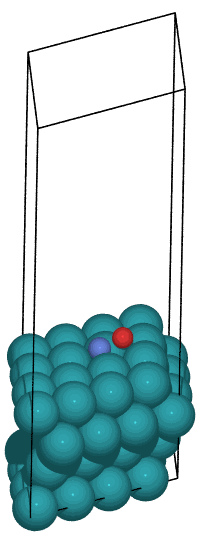

In [58]:
ImageWidget(f"output/{filepath}/vib.gif")

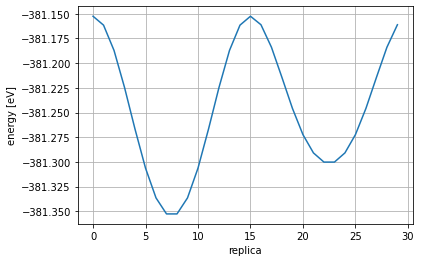

In [59]:
# 虚振動になっているか確認する。真ん中(と0)がTS。

vib_energies = []
for i in vib_traj:
    i.calc = calculator
    vib_energies.append(i.get_potential_energy())
plt.plot(range(len(vib_energies)), vib_energies)
plt.xlabel("replica")
plt.ylabel("energy [eV]")
plt.grid(True)
plt.show()